In [1]:
# -*- coding: utf-8 -*-
"""
STANDALONE LRMC (SOFT-IMPUTE) ONLY — NO Δ/δ METRICS

What this script does
---------------------
1) Load ORIGINAL full matrix, symmetrize & sanitize.
2) Generate EXACT 15 masked matrices (3 levels × 5 reps) from the original.
3) Run LRMC via Soft-Impute on ALL 15 masks, WITHOUT using np.linalg.svd (built-in SVD).
   - Uses a block power / subspace iteration to get a rank-k truncated SVD approximation.
   - Shrinks singular values by tau each iteration (standard Soft-Impute step).
4) Compute RMSE metrics only:
   - RMSE_vs_ORIG on all lower-triangle pairs
   - RMSE_missing_only on missing lower-triangle pairs only
5) Measure runtime for EACH run, and report mean ± std runtime per missingness level.
6) Save masked matrices, completed matrices, and CSV summary tables.

Notes on "true LRMC"
--------------------
This implements the classic Soft-Impute iteration for nuclear-norm-regularized LRMC,
but uses an approximate truncated SVD (no built-in SVD) for speed and compliance.
"""

import os, time, warnings
import numpy as np
import pandas as pd
from itertools import combinations

warnings.filterwarnings("ignore", category=UserWarning)

MISSING_VAL = -1.0

# -----------------------
# Loading & helpers
# -----------------------
def load_matrix_with_candidates(cands):
    tried = []
    for p in cands:
        tried.append(p)
        if os.path.exists(p):
            M = np.loadtxt(p)
            # Optional heuristic scaling (kept from your script)
            if np.nanmax(M) > 500:
                M = M / 1000.0
            return M, p
    raise FileNotFoundError(f"File not found. Tried: {tried}")

def symmetrize_full(D: np.ndarray) -> np.ndarray:
    D = 0.5 * (D + D.T)
    np.fill_diagonal(D, 0.0)
    return D

def symmetrize_with_missing(D: np.ndarray) -> np.ndarray:
    """Symmetrize an incomplete matrix where missing entries are -1."""
    D = D.copy().astype(float)
    n = D.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            a, b = D[i, j], D[j, i]
            if a >= 0 and b >= 0:
                v = 0.5 * (a + b)
            elif a >= 0:
                v = a
            elif b >= 0:
                v = b
            else:
                v = MISSING_VAL
            D[i, j] = D[j, i] = v
    np.fill_diagonal(D, 0.0)
    return D

def _finite_fill(v, fallback=1.0):
    v = np.asarray(v)
    if np.isfinite(v).any():
        return float(np.nanmedian(v[np.isfinite(v)]))
    return float(fallback)

def sanitize_distance_matrix(D: np.ndarray, name: str = "D", force_nonneg: bool = True) -> np.ndarray:
    """
    Sanitize FULL (complete) distance matrix:
      - replace negatives (off-diagonal) with median
      - clip extreme quantile
      - enforce symmetry and 0 diagonal
    Use this for the ORIGINAL matrix only (not for completed outputs if you must preserve observed entries).
    """
    M = np.array(D, dtype=float)
    n = M.shape[0]

    neg = (M < 0)
    np.fill_diagonal(neg, False)
    M[neg] = np.nan

    off = ~np.eye(n, dtype=bool)
    med = _finite_fill(M[off], fallback=1.0)
    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)

    q = np.quantile(M[off], 0.995)
    if np.isfinite(q) and q > 0:
        M[off] = np.minimum(M[off], q)

    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)

    if not np.isfinite(M).all():
        raise ValueError(f"{name} has non-finite entries after sanitize.")
    return M

# -----------------------
# RMSE helpers
# -----------------------
def rmse_on_lt(A: np.ndarray, B: np.ndarray) -> float:
    n = A.shape[0]
    i_lt, j_lt = np.tril_indices(n, k=-1)
    diff = (A - B)[i_lt, j_lt]
    return float(np.sqrt(np.mean(diff * diff)))

def rmse_on_missing_lt(A: np.ndarray, B: np.ndarray, obs_mask: np.ndarray) -> float:
    """
    RMSE only over missing entries in the LOWER triangle (k=-1).
    obs_mask True means observed; False means missing.
    """
    n = A.shape[0]
    lower = np.tril(np.ones((n, n), dtype=bool), k=-1)
    miss = lower & (~obs_mask)
    ii, jj = np.where(miss)
    if len(ii) == 0:
        return 0.0
    diff = (A - B)[ii, jj]
    return float(np.sqrt(np.mean(diff * diff)))

# -----------------------
# Mask generation — reproducible set of 15
# -----------------------
def simulate_missing(D_full: np.ndarray, frac_missing: float, rng: np.random.RandomState):
    """Mask lower-triangle pairs to -1 (symmetrically) at given fraction."""
    n = D_full.shape[0]
    lower = np.tril(np.ones((n, n), dtype=bool), k=-1)
    I, J = np.where(lower)
    m = len(I)

    drop = int(round(frac_missing * m))
    keep = np.ones(m, dtype=bool)
    if drop > 0:
        keep[rng.choice(m, size=drop, replace=False)] = False

    D_inc = D_full.copy().astype(float)
    for idx in range(m):
        i, j = I[idx], J[idx]
        if not keep[idx]:
            D_inc[i, j] = D_inc[j, i] = MISSING_VAL

    np.fill_diagonal(D_inc, 0.0)
    D_inc = symmetrize_with_missing(D_inc)

    obs_mask = (D_inc >= 0)
    np.fill_diagonal(obs_mask, True)
    return D_inc, obs_mask

# -----------------------
# Truncated SVD approximation (NO np.linalg.svd)
#   Block power / subspace iteration + tiny eigendecomposition
# -----------------------
def gram_schmidt(A: np.ndarray, rng: np.random.RandomState, eps: float = 1e-12) -> np.ndarray:
    """Orthonormalize columns of A via classical Gram-Schmidt."""
    m, k = A.shape
    Q = np.zeros((m, k), dtype=float)
    for i in range(k):
        v = A[:, i].copy()
        for j in range(i):
            v -= np.dot(Q[:, j], v) * Q[:, j]
        nrm = np.linalg.norm(v)
        if nrm < eps:
            # re-seed this direction deterministically
            v = rng.randn(m)
            for j in range(i):
                v -= np.dot(Q[:, j], v) * Q[:, j]
            nrm = np.linalg.norm(v)
        if nrm >= eps:
            Q[:, i] = v / nrm
        else:
            Q[:, i] = 0.0
    return Q

def svd_truncated_power(Y: np.ndarray, k: int, rng: np.random.RandomState, n_power: int = 2):
    """
    Approximate truncated SVD of Y (m x n) without np.linalg.svd:
      1) Build orthonormal subspaces Uhat, Vhat by block power iteration
      2) Form small core B = Uhat^T Y Vhat (k x k)
      3) Compute SVD of B via eigendecomposition (k is small)
      4) Lift back to get U, s, Vt
    """
    m, n = Y.shape
    k = min(k, m, n)
    if k <= 0:
        return np.zeros((m, 0)), np.zeros((0,)), np.zeros((0, n))

    V = gram_schmidt(rng.randn(n, k), rng)
    U = None

    # block power iterations
    for _ in range(max(1, n_power)):
        U = gram_schmidt(Y @ V, rng)
        V = gram_schmidt(Y.T @ U, rng)

    # small core
    B = (U.T @ Y) @ V  # (k x k)

    # SVD of small B via eigendecomposition on BB^T
    C = B @ B.T  # symmetric (k x k)
    evals, Ub = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    Ub = Ub[:, idx]

    s = np.sqrt(np.maximum(evals, 0.0))
    # compute Vb = B^T Ub / s
    Vb = np.zeros((k, k), dtype=float)
    for i in range(k):
        if s[i] > 1e-12:
            Vb[:, i] = (B.T @ Ub[:, i]) / s[i]
        else:
            Vb[:, i] = 0.0

    # lift
    U_full = U @ Ub           # (m x k)
    V_full = V @ Vb           # (n x k)
    Vt = V_full.T             # (k x n)

    return U_full, s, Vt

# -----------------------
# Soft-Impute (LRMC) implementation
# -----------------------
def soft_impute_lrmc(
    D_in: np.ndarray,
    obs_mask: np.ndarray,
    tau: float = 0.02,
    iters: int = 200,
    tol: float = 1e-5,
    k: int = 10,
    n_power: int = 2,
    seed: int = 0,
    enforce_nonneg_final: bool = True,
) -> np.ndarray:
    """
    Soft-Impute LRMC:
      Y = P_O(D_obs) + P_M(X)
      X <- S_tau(Y)
    Final output preserves observed entries EXACTLY.

    enforce_nonneg_final:
      If True, clips only the IMPUTED (missing) entries to >=0 at the end
      (observed entries are still preserved exactly).
    """
    rng = np.random.RandomState(seed)
    n = D_in.shape[0]

    # Observed matrix (missing -> 0 in this holder)
    M_obs = np.where(obs_mask, D_in, 0.0)

    # Initialize with observed values (missing -> 0)
    X = M_obs.copy()

    for t in range(1, iters + 1):
        # Project onto observed entries
        Y = np.where(obs_mask, M_obs, X)

        # Enforce symmetry & zero diagonal (distance-matrix structure)
        Y = 0.5 * (Y + Y.T)
        np.fill_diagonal(Y, 0.0)

        # Truncated SVD approximation and shrinkage
        U, s, Vt = svd_truncated_power(Y, k=min(k, n), rng=rng, n_power=n_power)
        if s.size == 0:
            break

        s_thr = np.maximum(s - tau, 0.0)
        X_new = (U * s_thr) @ Vt

        # Enforce symmetry & zero diagonal
        X_new = 0.5 * (X_new + X_new.T)
        np.fill_diagonal(X_new, 0.0)

        # Convergence check
        denom = np.linalg.norm(X, "fro") + 1e-12
        rel = np.linalg.norm(X_new - X, "fro") / denom
        X = X_new
        if rel < tol:
            break

    # Finalize: preserve observed exactly
    D_out = np.where(obs_mask, D_in, X)

    # Symmetry & diagonal
    D_out = 0.5 * (D_out + D_out.T)
    np.fill_diagonal(D_out, 0.0)

    # Optional: enforce nonnegativity only on missing entries
    if enforce_nonneg_final:
        miss_mask = ~obs_mask
        D_out[miss_mask] = np.maximum(D_out[miss_mask], 0.0)

    return D_out

# -----------------------
# MAIN FLOW
# -----------------------
# Load ORIGINAL only
D_orig, used_orig_path = load_matrix_with_candidates([
    "Result_NW_15x15.txt",
    "./Result_NW_20x20.txtt",
    "/mnt/data/Result_NW_20x20.txt"
])
D0 = sanitize_distance_matrix(symmetrize_full(D_orig), "D_orig")
n = D0.shape[0]
labels = [f"T{i+1}" for i in range(n)]

print("=== ORIGINAL MATRIX INFO ===")
print(f"Used file: {used_orig_path}")
print(f"n = {n}")
print()

# Build & freeze EXACT 15 masked matrices (3 levels × 5 reps)
MISSING_FRACS = (0.30, 0.50, 0.65, 0.85, 0.90)
REPS = 5
BASE_SEED = 55  # kept to match your reproducible mask registry behavior

masked_registry = []
for frac in MISSING_FRACS:
    for r in range(1, REPS + 1):
        rng = np.random.RandomState(BASE_SEED + (r - 1))
        D_inc, obs_mask = simulate_missing(D0, frac, rng)
        masked_registry.append({"frac": frac, "rep": r, "D_inc": D_inc, "obs_mask": obs_mask})

# Save all 15 masked matrices
masked_dir = "lrmc_missing_matrices"
os.makedirs(masked_dir, exist_ok=True)
for rec in masked_registry:
    pct = int(round(100 * rec["frac"]))
    fn = f"missing_p{pct}_rep{rec['rep']}.csv"
    pd.DataFrame(rec["D_inc"], index=labels, columns=labels).to_csv(os.path.join(masked_dir, fn))

# Run LRMC on ALL 15 masks
print("=== Running LRMC (Soft-Impute; no built-in SVD) on all 15 masks ===")
results = []
completed_dir = "lrmc_completed_matrices"
os.makedirs(completed_dir, exist_ok=True)

for rec in masked_registry:
    frac = rec["frac"]
    rep = rec["rep"]
    D_inc = rec["D_inc"]
    obs_mask = rec["obs_mask"]
    pct = int(round(100 * frac))

    print(f"  Processing {pct}% missing, replicate {rep}...")

    t0 = time.perf_counter()
    D_hat = soft_impute_lrmc(
        D_in=D_inc,
        obs_mask=obs_mask,
        tau=0.02,
        iters=200,
        tol=1e-5,
        k=min(10, n),
        n_power=2,
        seed=10000 * pct + rep,          # deterministic per (pct,rep)
        enforce_nonneg_final=True
    )
    t1 = time.perf_counter()
    runtime_sec = t1 - t0

    # Metrics
    rmse_all = rmse_on_lt(D_hat, D0)
    rmse_miss = rmse_on_missing_lt(D_hat, D0, obs_mask)

    # Save completed matrix
    out_fn = f"LRMC_completed_p{pct}_rep{rep}.csv"
    pd.DataFrame(D_hat, index=labels, columns=labels).to_csv(os.path.join(completed_dir, out_fn))

    results.append({
        "pct_missing": pct,
        "replicate": rep,
        "RMSE_vs_ORIG_all_LT": rmse_all,
        "RMSE_missing_only_LT": rmse_miss,
        "runtime_seconds": runtime_sec,
        "completed_file": out_fn
    })

results_df = pd.DataFrame(results)
print("\n=== LRMC results (all 15 masks) ===")
try:
    from IPython.display import display
    display(results_df)
except Exception:
    print(results_df.to_string(index=False))

results_df.to_csv("lrmc_all_masks_detailed.csv", index=False)

# Summary table: mean ± std over 5 replicates, INCLUDING mean time per missingness
def fmt_pm(mean_val, std_val, decimals=4):
    return f"{mean_val:.{decimals}f} ± {std_val:.{decimals}f}"

summary_rows = []
for frac in MISSING_FRACS:
    pct = int(round(100 * frac))
    sub = results_df[results_df["pct_missing"] == pct]

    rmse_all_mean = sub["RMSE_vs_ORIG_all_LT"].mean()
    rmse_all_std  = sub["RMSE_vs_ORIG_all_LT"].std(ddof=1)

    rmse_m_mean = sub["RMSE_missing_only_LT"].mean()
    rmse_m_std  = sub["RMSE_missing_only_LT"].std(ddof=1)

    t_mean = sub["runtime_seconds"].mean()
    t_std  = sub["runtime_seconds"].std(ddof=1)

    summary_rows.append({
        "% Missing": f"{pct}%",
        "RMSE_all_LT_mean": rmse_all_mean,
        "RMSE_all_LT_std": rmse_all_std,
        "RMSE_missing_LT_mean": rmse_m_mean,
        "RMSE_missing_LT_std": rmse_m_std,
        "time_sec_mean": t_mean,
        "time_sec_std": t_std,
        "time_min_mean": t_mean / 60.0,
        "time_min_std": t_std / 60.0,
    })

summary_df = pd.DataFrame(summary_rows)

formatted = pd.DataFrame({
    "% Missing": summary_df["% Missing"],
    "RMSE_all_LT": [fmt_pm(m, s, 6) for m, s in zip(summary_df["RMSE_all_LT_mean"], summary_df["RMSE_all_LT_std"])],
    "RMSE_missing_LT": [fmt_pm(m, s, 6) for m, s in zip(summary_df["RMSE_missing_LT_mean"], summary_df["RMSE_missing_LT_std"])],
    "Mean time (sec)": [fmt_pm(m, s, 2) for m, s in zip(summary_df["time_sec_mean"], summary_df["time_sec_std"])],
    "Mean time (min)": [fmt_pm(m, s, 3) for m, s in zip(summary_df["time_min_mean"], summary_df["time_min_std"])],
})

print("\n=== LRMC summary (mean ± std over 5 replicates) ===")
try:
    from IPython.display import display
    display(formatted)
except Exception:
    print(formatted.to_string(index=False))

summary_df.to_csv("lrmc_summary_numeric.csv", index=False)
formatted.to_csv("lrmc_summary_formatted.csv", index=False)

print("\n=== ALL PROCESSING COMPLETE! ===")
print("Output files:")
print(f"  - Masked matrices: {masked_dir}/")
print(f"  - Completed matrices: {completed_dir}/")
print(f"  - Detailed results: lrmc_all_masks_detailed.csv")
print(f"  - Summary (numeric): lrmc_summary_numeric.csv")
print(f"  - Summary (formatted): lrmc_summary_formatted.csv")


=== ORIGINAL MATRIX INFO ===
Used file: Result_NW_15x15.txt
n = 15

=== Running LRMC (Soft-Impute; no built-in SVD) on all 15 masks ===
  Processing 30% missing, replicate 1...
  Processing 30% missing, replicate 2...
  Processing 30% missing, replicate 3...
  Processing 30% missing, replicate 4...
  Processing 30% missing, replicate 5...
  Processing 50% missing, replicate 1...
  Processing 50% missing, replicate 2...
  Processing 50% missing, replicate 3...
  Processing 50% missing, replicate 4...
  Processing 50% missing, replicate 5...
  Processing 65% missing, replicate 1...
  Processing 65% missing, replicate 2...
  Processing 65% missing, replicate 3...
  Processing 65% missing, replicate 4...
  Processing 65% missing, replicate 5...
  Processing 85% missing, replicate 1...
  Processing 85% missing, replicate 2...
  Processing 85% missing, replicate 3...
  Processing 85% missing, replicate 4...
  Processing 85% missing, replicate 5...
  Processing 90% missing, replicate 1...
  P

,pct_missing,replicate,RMSE_vs_ORIG_all_LT,RMSE_missing_only_LT,runtime_seconds,completed_file
0,30,1,0.027095,0.049080,0.070208,LRMC_completed_p30_rep1.csv
1,30,2,0.029926,0.054208,0.070300,LRMC_completed_p30_rep2.csv
2,30,3,0.030198,0.054701,0.075675,LRMC_completed_p30_rep3.csv
3,30,4,0.029700,0.053799,0.067281,LRMC_completed_p30_rep4.csv
4,30,5,0.031859,0.057711,0.070592,LRMC_completed_p30_rep5.csv
5,50,1,0.044326,0.062987,0.074705,LRMC_completed_p50_rep1.csv
6,50,2,0.045983,0.065341,0.067425,LRMC_completed_p50_rep2.csv
7,50,3,0.046953,0.066720,0.065706,LRMC_completed_p50_rep3.csv
8,50,4,0.043286,0.061509,0.065458,LRMC_completed_p50_rep4.csv
9,50,5,0.048964,0.069578,0.068214,LRMC_completed_p50_rep5.csv



=== LRMC summary (mean ± std over 5 replicates) ===


,% Missing,RMSE_all_LT,RMSE_missing_LT,Mean time (sec),Mean time (min)
0,30%,0.029756 ± 0.001713,0.053900 ± 0.003102,0.07 ± 0.00,0.001 ± 0.000
1,50%,0.045902 ± 0.002226,0.065227 ± 0.003163,0.07 ± 0.00,0.001 ± 0.000
2,65%,0.061161 ± 0.005443,0.076000 ± 0.006763,0.08 ± 0.00,0.001 ± 0.000
3,85%,0.102313 ± 0.005986,0.111130 ± 0.006502,0.07 ± 0.00,0.001 ± 0.000
4,90%,0.118378 ± 0.003493,0.125113 ± 0.003692,0.07 ± 0.00,0.001 ± 0.000



=== ALL PROCESSING COMPLETE! ===
Output files:
  - Masked matrices: lrmc_missing_matrices/
  - Completed matrices: lrmc_completed_matrices/
  - Detailed results: lrmc_all_masks_detailed.csv
  - Summary (numeric): lrmc_summary_numeric.csv
  - Summary (formatted): lrmc_summary_formatted.csv


Loading original matrix...
  Original matrix loaded: Result_NW_15x15.txt
  Original matrix shape: (15, 15)

Processing LRMC completed matrices -> NJ trees for 30% missing (rep1..5)

----------------------------------------------------------------------
p30 | replicate 1: lrmc_completed_matrices/LRMC_completed_p30_rep1.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p30_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


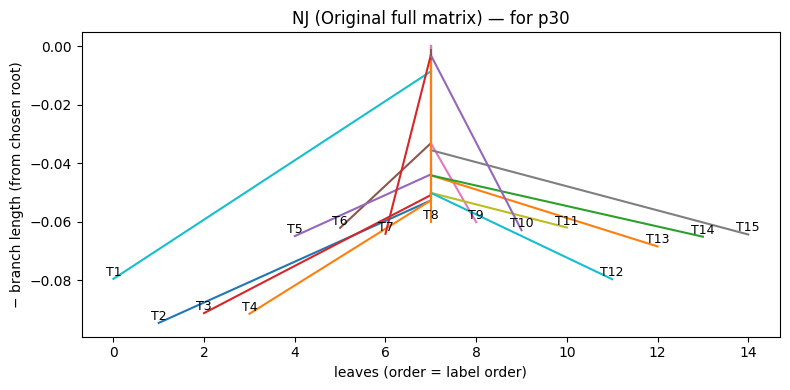

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for LRMC...
    LRMC NJ tree built


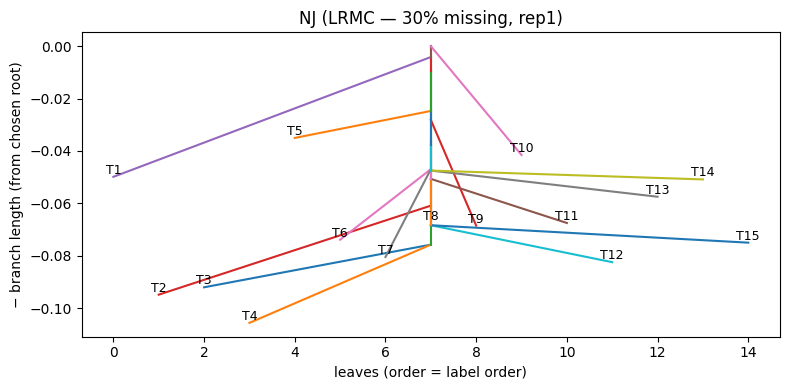

    Saved: tree_LRMC_rep1.png, tree_LRMC_rep1.newick

  Summary p30 rep1:
    RF_norm=0.833333 | pat_RMSE=0.025779 | mat_RMSE=0.027095

----------------------------------------------------------------------
p30 | replicate 2: lrmc_completed_matrices/LRMC_completed_p30_rep2.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p30_rep2.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


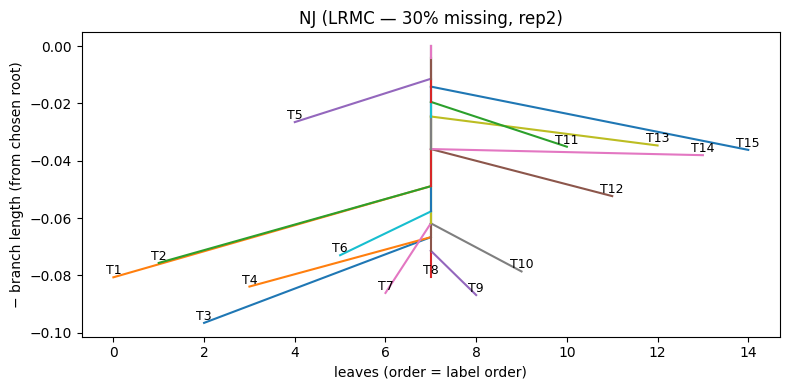

    Saved: tree_LRMC_rep2.png, tree_LRMC_rep2.newick

  Summary p30 rep2:
    RF_norm=0.750000 | pat_RMSE=0.031114 | mat_RMSE=0.029926

----------------------------------------------------------------------
p30 | replicate 3: lrmc_completed_matrices/LRMC_completed_p30_rep3.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p30_rep3.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


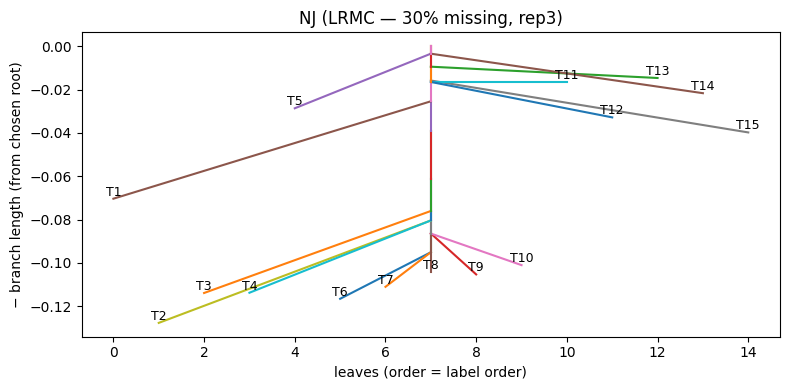

    Saved: tree_LRMC_rep3.png, tree_LRMC_rep3.newick

  Summary p30 rep3:
    RF_norm=0.750000 | pat_RMSE=0.025062 | mat_RMSE=0.030198

----------------------------------------------------------------------
p30 | replicate 4: lrmc_completed_matrices/LRMC_completed_p30_rep4.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p30_rep4.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


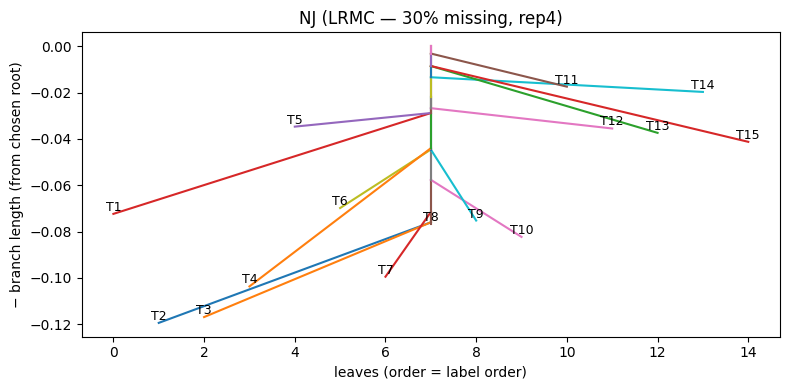

    Saved: tree_LRMC_rep4.png, tree_LRMC_rep4.newick

  Summary p30 rep4:
    RF_norm=0.916667 | pat_RMSE=0.030935 | mat_RMSE=0.029700

----------------------------------------------------------------------
p30 | replicate 5: lrmc_completed_matrices/LRMC_completed_p30_rep5.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p30_rep5.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


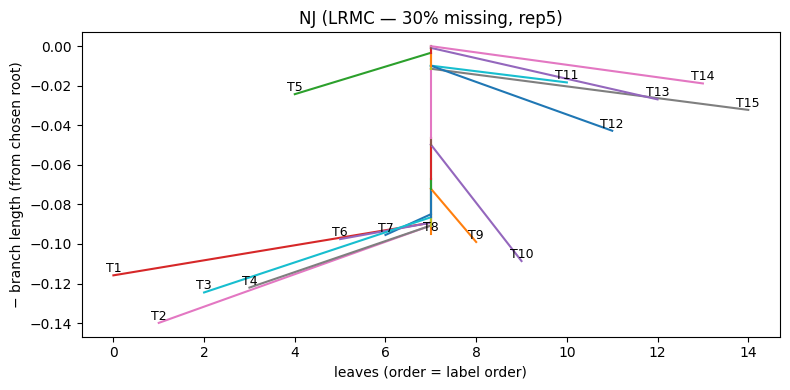

    Saved: tree_LRMC_rep5.png, tree_LRMC_rep5.newick

  Summary p30 rep5:
    RF_norm=0.666667 | pat_RMSE=0.025563 | mat_RMSE=0.031859

Processing LRMC completed matrices -> NJ trees for 50% missing (rep1..5)

----------------------------------------------------------------------
p50 | replicate 1: lrmc_completed_matrices/LRMC_completed_p50_rep1.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p50_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


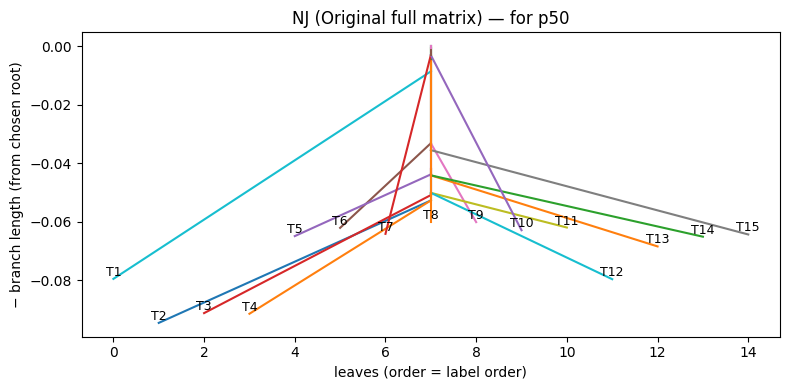

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for LRMC...
    LRMC NJ tree built


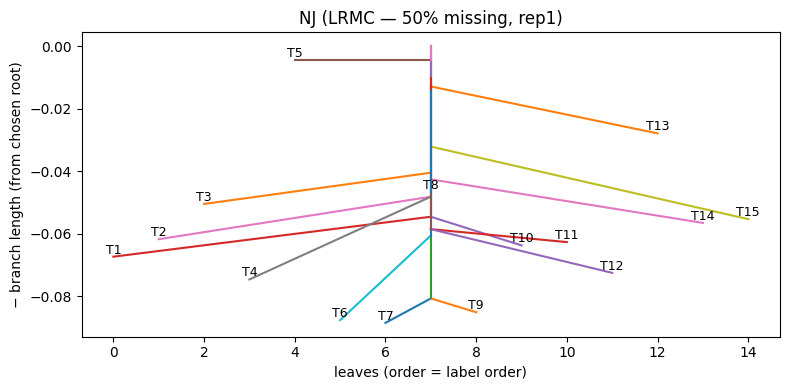

    Saved: tree_LRMC_rep1.png, tree_LRMC_rep1.newick

  Summary p50 rep1:
    RF_norm=0.833333 | pat_RMSE=0.043391 | mat_RMSE=0.044326

----------------------------------------------------------------------
p50 | replicate 2: lrmc_completed_matrices/LRMC_completed_p50_rep2.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p50_rep2.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


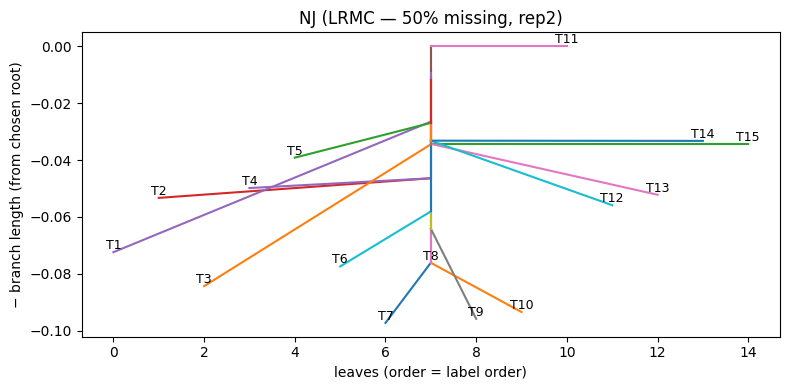

    Saved: tree_LRMC_rep2.png, tree_LRMC_rep2.newick

  Summary p50 rep2:
    RF_norm=0.750000 | pat_RMSE=0.044211 | mat_RMSE=0.045982

----------------------------------------------------------------------
p50 | replicate 3: lrmc_completed_matrices/LRMC_completed_p50_rep3.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p50_rep3.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


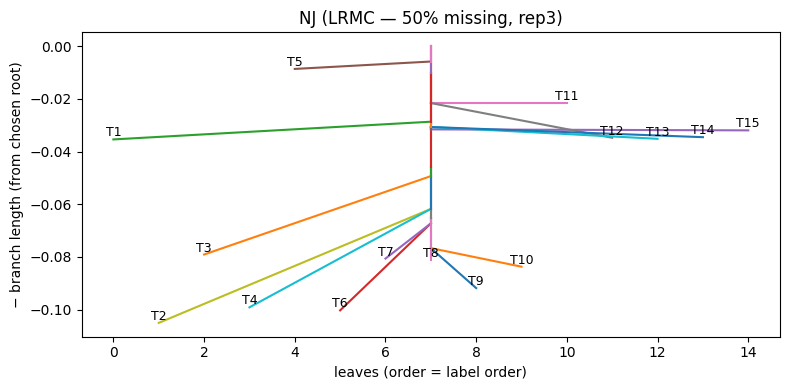

    Saved: tree_LRMC_rep3.png, tree_LRMC_rep3.newick

  Summary p50 rep3:
    RF_norm=0.583333 | pat_RMSE=0.041871 | mat_RMSE=0.046953

----------------------------------------------------------------------
p50 | replicate 4: lrmc_completed_matrices/LRMC_completed_p50_rep4.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p50_rep4.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


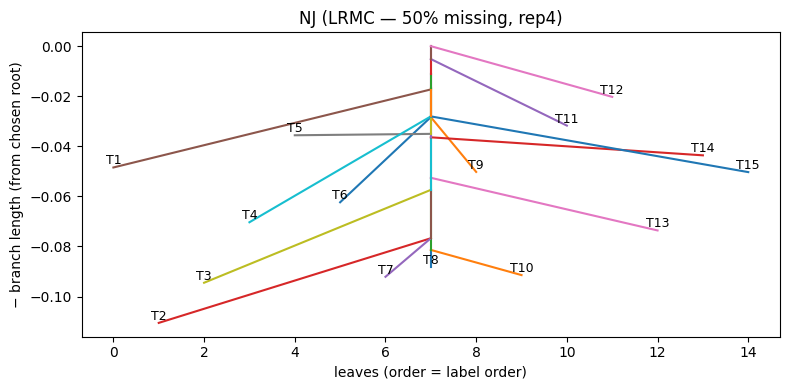

    Saved: tree_LRMC_rep4.png, tree_LRMC_rep4.newick

  Summary p50 rep4:
    RF_norm=0.916667 | pat_RMSE=0.042828 | mat_RMSE=0.043286

----------------------------------------------------------------------
p50 | replicate 5: lrmc_completed_matrices/LRMC_completed_p50_rep5.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p50_rep5.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


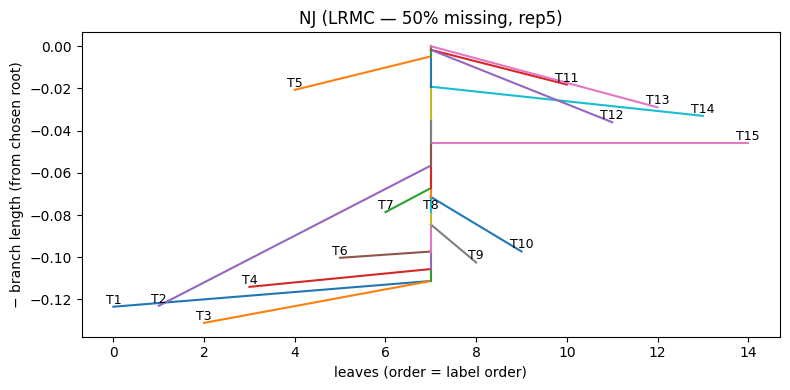

    Saved: tree_LRMC_rep5.png, tree_LRMC_rep5.newick

  Summary p50 rep5:
    RF_norm=0.916667 | pat_RMSE=0.044518 | mat_RMSE=0.048964

Processing LRMC completed matrices -> NJ trees for 65% missing (rep1..5)

----------------------------------------------------------------------
p65 | replicate 1: lrmc_completed_matrices/LRMC_completed_p65_rep1.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p65_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


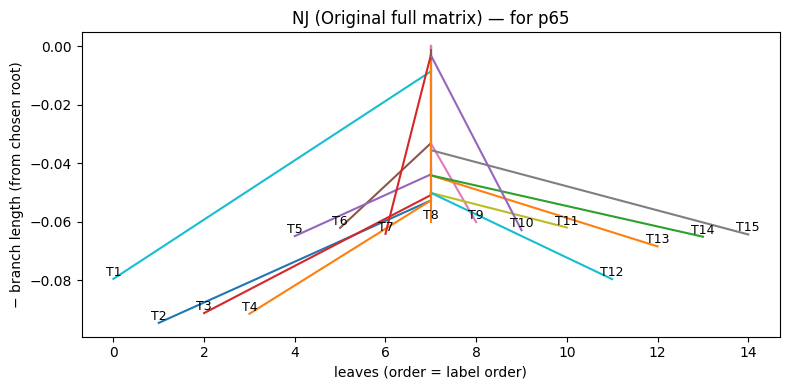

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for LRMC...
    LRMC NJ tree built


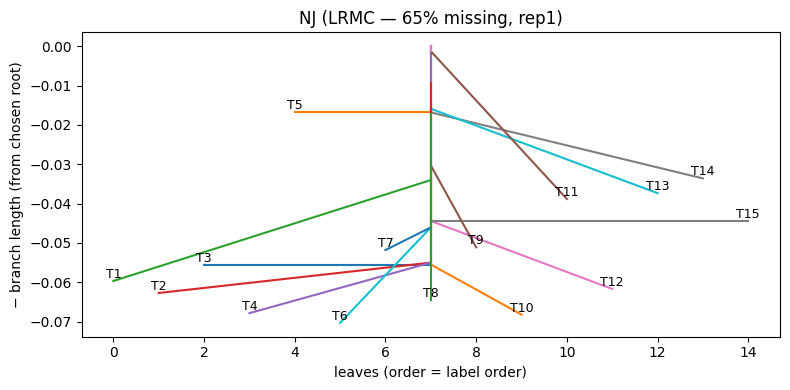

    Saved: tree_LRMC_rep1.png, tree_LRMC_rep1.newick

  Summary p65 rep1:
    RF_norm=0.916667 | pat_RMSE=0.051233 | mat_RMSE=0.061364

----------------------------------------------------------------------
p65 | replicate 2: lrmc_completed_matrices/LRMC_completed_p65_rep2.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p65_rep2.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


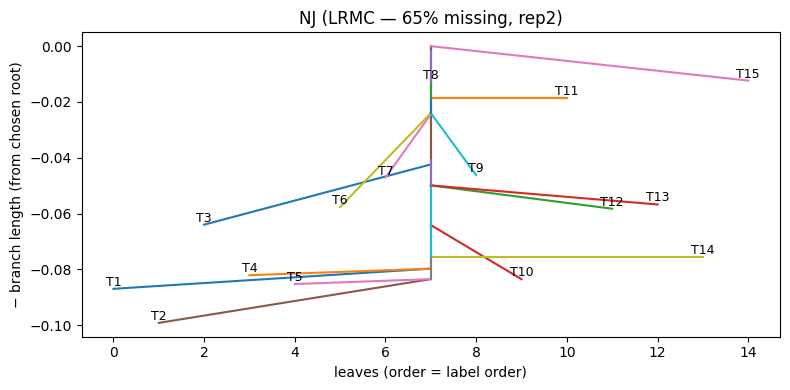

    Saved: tree_LRMC_rep2.png, tree_LRMC_rep2.newick

  Summary p65 rep2:
    RF_norm=0.916667 | pat_RMSE=0.053434 | mat_RMSE=0.062577

----------------------------------------------------------------------
p65 | replicate 3: lrmc_completed_matrices/LRMC_completed_p65_rep3.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p65_rep3.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


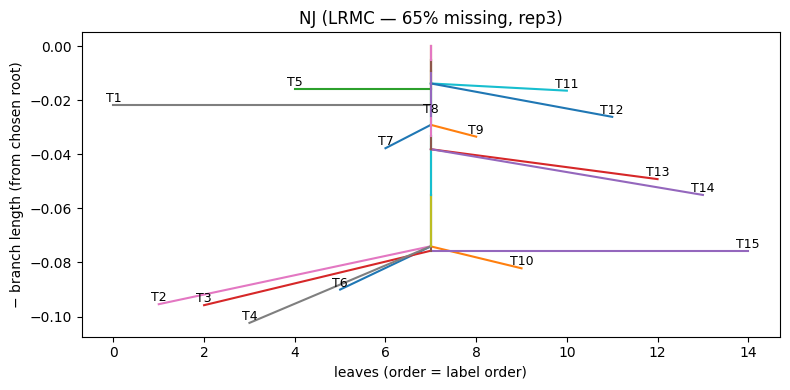

    Saved: tree_LRMC_rep3.png, tree_LRMC_rep3.newick

  Summary p65 rep3:
    RF_norm=0.750000 | pat_RMSE=0.056152 | mat_RMSE=0.059362

----------------------------------------------------------------------
p65 | replicate 4: lrmc_completed_matrices/LRMC_completed_p65_rep4.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p65_rep4.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


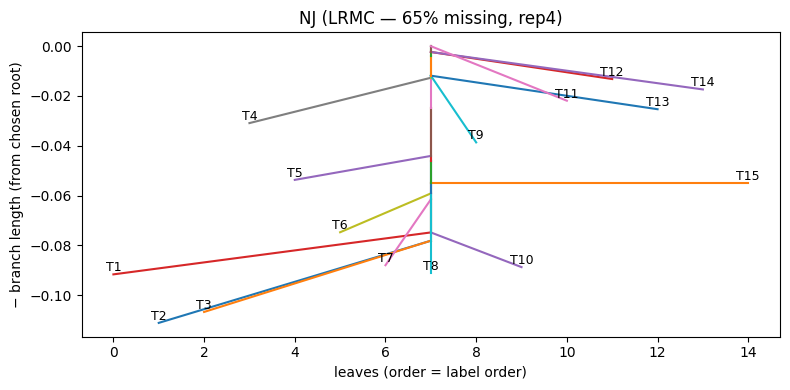

    Saved: tree_LRMC_rep4.png, tree_LRMC_rep4.newick

  Summary p65 rep4:
    RF_norm=1.000000 | pat_RMSE=0.050915 | mat_RMSE=0.053729

----------------------------------------------------------------------
p65 | replicate 5: lrmc_completed_matrices/LRMC_completed_p65_rep5.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p65_rep5.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


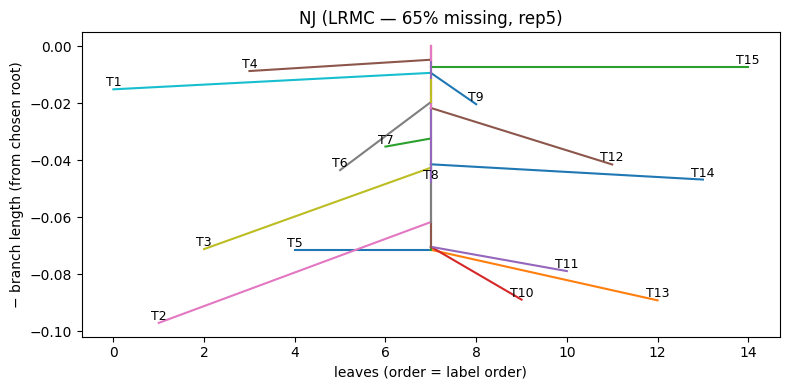

    Saved: tree_LRMC_rep5.png, tree_LRMC_rep5.newick

  Summary p65 rep5:
    RF_norm=1.000000 | pat_RMSE=0.066461 | mat_RMSE=0.068775

Processing LRMC completed matrices -> NJ trees for 85% missing (rep1..5)

----------------------------------------------------------------------
p85 | replicate 1: lrmc_completed_matrices/LRMC_completed_p85_rep1.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p85_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


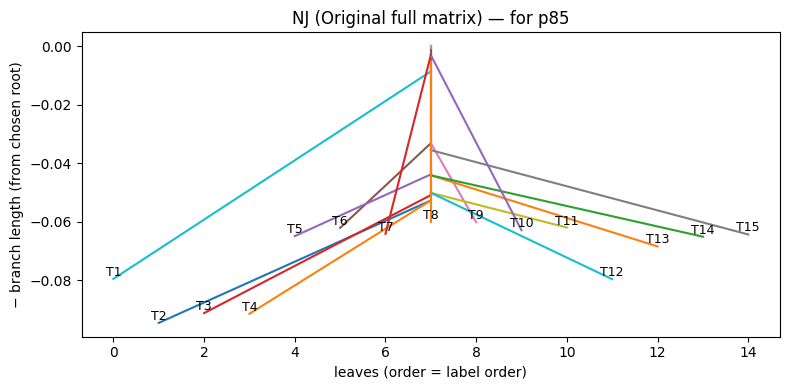

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for LRMC...
    LRMC NJ tree built


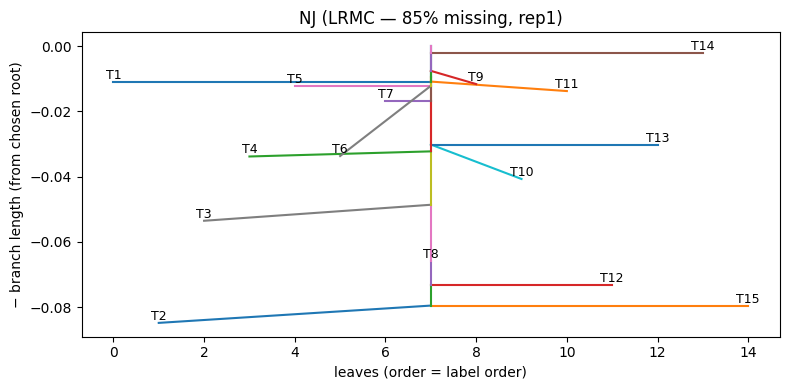

    Saved: tree_LRMC_rep1.png, tree_LRMC_rep1.newick

  Summary p85 rep1:
    RF_norm=1.000000 | pat_RMSE=0.084919 | mat_RMSE=0.099437

----------------------------------------------------------------------
p85 | replicate 2: lrmc_completed_matrices/LRMC_completed_p85_rep2.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p85_rep2.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


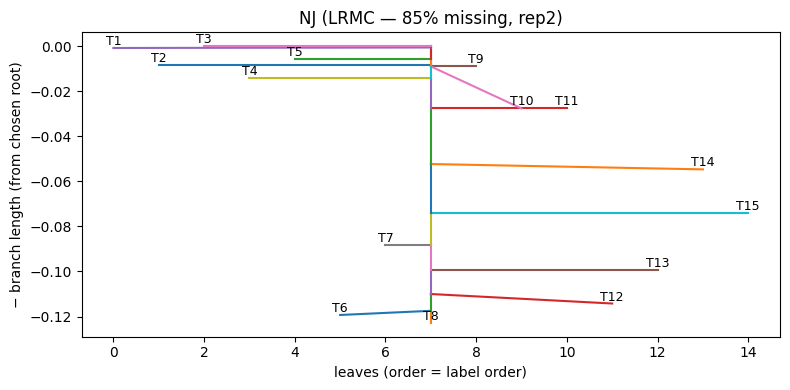

    Saved: tree_LRMC_rep2.png, tree_LRMC_rep2.newick

  Summary p85 rep2:
    RF_norm=1.000000 | pat_RMSE=0.083714 | mat_RMSE=0.094054

----------------------------------------------------------------------
p85 | replicate 3: lrmc_completed_matrices/LRMC_completed_p85_rep3.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p85_rep3.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


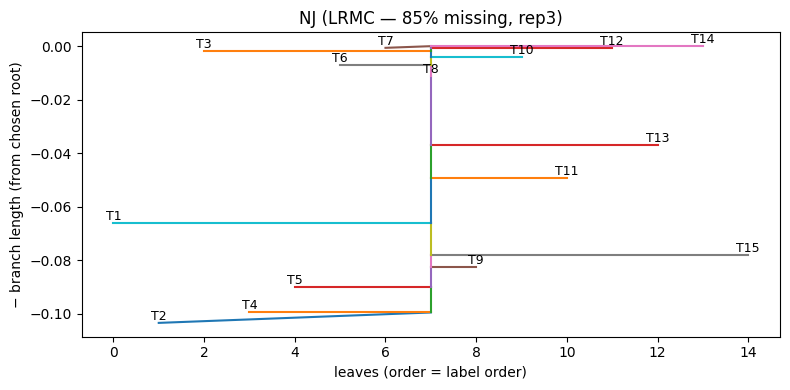

    Saved: tree_LRMC_rep3.png, tree_LRMC_rep3.newick

  Summary p85 rep3:
    RF_norm=0.916667 | pat_RMSE=0.092952 | mat_RMSE=0.109807

----------------------------------------------------------------------
p85 | replicate 4: lrmc_completed_matrices/LRMC_completed_p85_rep4.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p85_rep4.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


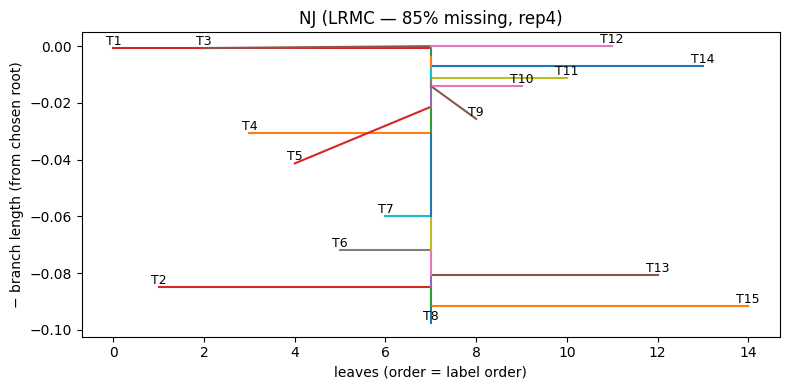

    Saved: tree_LRMC_rep4.png, tree_LRMC_rep4.newick

  Summary p85 rep4:
    RF_norm=1.000000 | pat_RMSE=0.091309 | mat_RMSE=0.105556

----------------------------------------------------------------------
p85 | replicate 5: lrmc_completed_matrices/LRMC_completed_p85_rep5.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p85_rep5.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


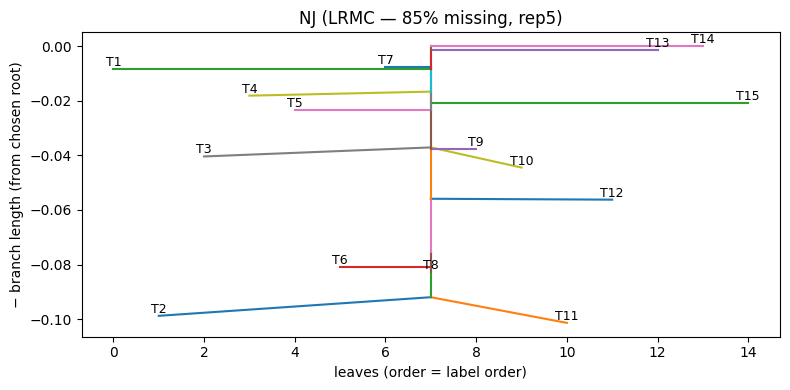

    Saved: tree_LRMC_rep5.png, tree_LRMC_rep5.newick

  Summary p85 rep5:
    RF_norm=1.000000 | pat_RMSE=0.086136 | mat_RMSE=0.102713

Processing LRMC completed matrices -> NJ trees for 90% missing (rep1..5)

----------------------------------------------------------------------
p90 | replicate 1: lrmc_completed_matrices/LRMC_completed_p90_rep1.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p90_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


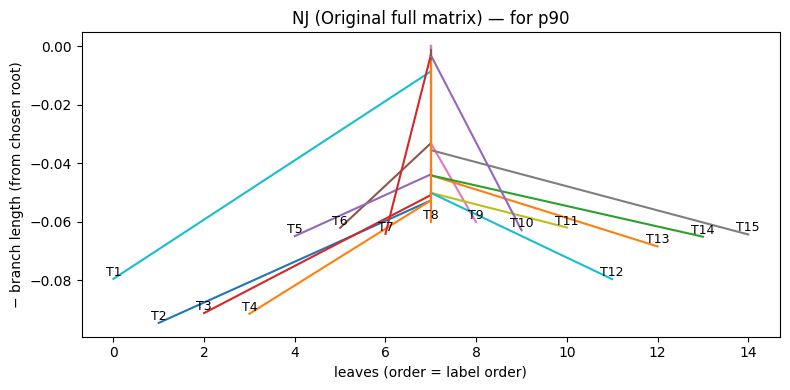

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for LRMC...
    LRMC NJ tree built


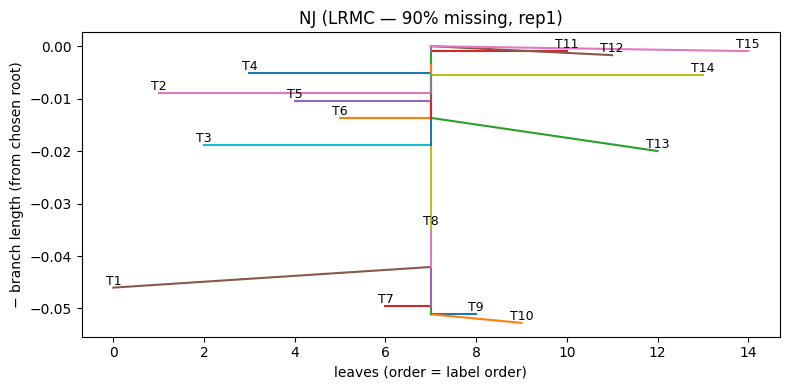

    Saved: tree_LRMC_rep1.png, tree_LRMC_rep1.newick

  Summary p90 rep1:
    RF_norm=1.000000 | pat_RMSE=0.105080 | mat_RMSE=0.119941

----------------------------------------------------------------------
p90 | replicate 2: lrmc_completed_matrices/LRMC_completed_p90_rep2.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p90_rep2.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


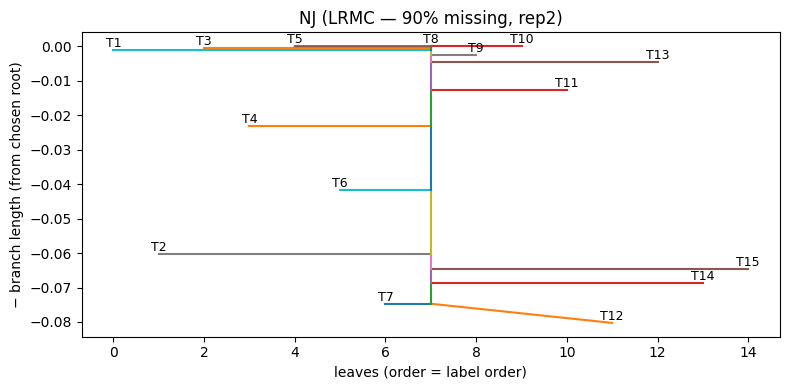

    Saved: tree_LRMC_rep2.png, tree_LRMC_rep2.newick

  Summary p90 rep2:
    RF_norm=1.000000 | pat_RMSE=0.102232 | mat_RMSE=0.114336

----------------------------------------------------------------------
p90 | replicate 3: lrmc_completed_matrices/LRMC_completed_p90_rep3.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p90_rep3.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


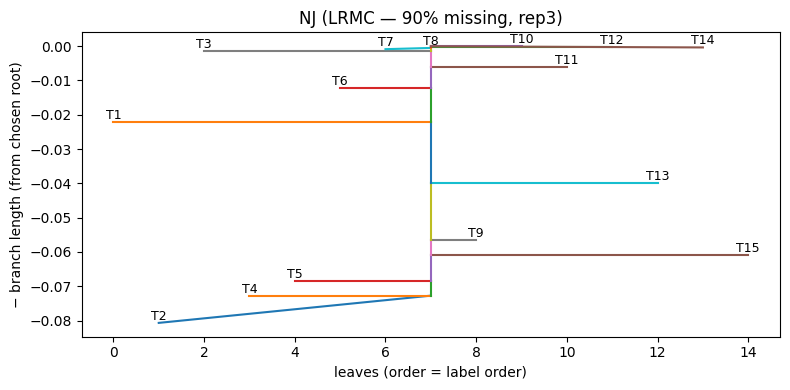

    Saved: tree_LRMC_rep3.png, tree_LRMC_rep3.newick

  Summary p90 rep3:
    RF_norm=0.916667 | pat_RMSE=0.101361 | mat_RMSE=0.116896

----------------------------------------------------------------------
p90 | replicate 4: lrmc_completed_matrices/LRMC_completed_p90_rep4.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p90_rep4.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


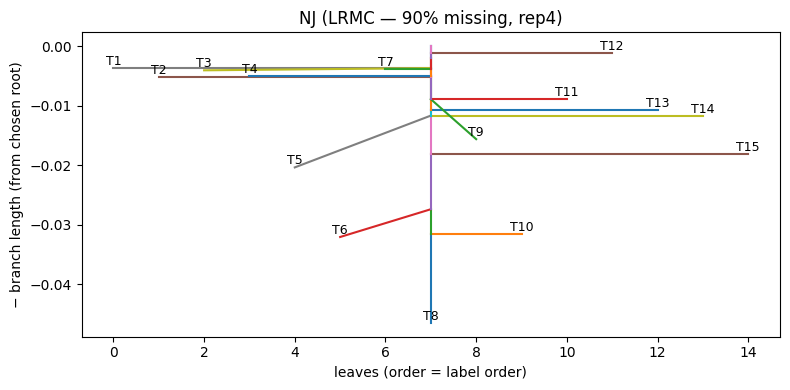

    Saved: tree_LRMC_rep4.png, tree_LRMC_rep4.newick

  Summary p90 rep4:
    RF_norm=1.000000 | pat_RMSE=0.110293 | mat_RMSE=0.123521

----------------------------------------------------------------------
p90 | replicate 5: lrmc_completed_matrices/LRMC_completed_p90_rep5.csv
----------------------------------------------------------------------
  Loaded LRMC completed matrix: LRMC_completed_p90_rep5.csv | shape=(15, 15)
  Building NJ tree for LRMC...
    LRMC NJ tree built


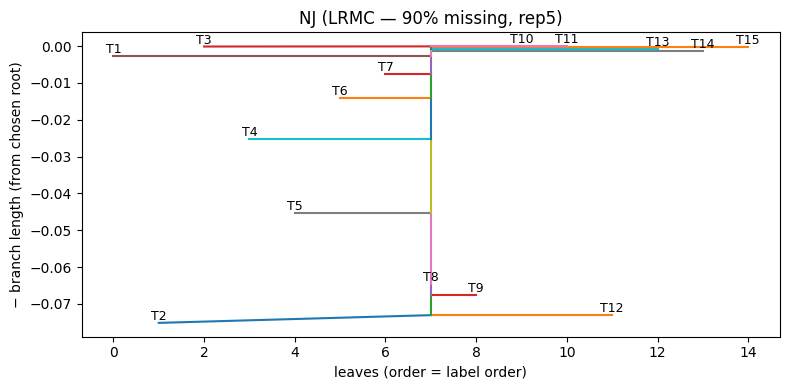

    Saved: tree_LRMC_rep5.png, tree_LRMC_rep5.newick

  Summary p90 rep5:
    RF_norm=1.000000 | pat_RMSE=0.103802 | mat_RMSE=0.117197

Detailed Tree Benchmark Results (ALL processed)
 pct_missing  replicate                        file  RF  RF_norm  n_splits  pat_MAE  pat_RMSE  pat_Pearson  pat_Spearman
          30          1 LRMC_completed_p30_rep1.csv  20 0.833333        12 0.018363  0.025779     0.796664      0.709278
          30          2 LRMC_completed_p30_rep2.csv  18 0.750000        12 0.024699  0.031114     0.703983      0.572268
          30          3 LRMC_completed_p30_rep3.csv  18 0.750000        12 0.016890  0.025062     0.843273      0.779028
          30          4 LRMC_completed_p30_rep4.csv  22 0.916667        12 0.022483  0.030935     0.691899      0.636098
          30          5 LRMC_completed_p30_rep5.csv  16 0.666667        12 0.015632  0.025563     0.824950      0.785486
          50          1 LRMC_completed_p50_rep1.csv  20 0.833333        12 0.032623  0.043

In [2]:
# Cell — PICTURES OF TREES (30/50/65/85/90% missing × 5 replicates) for LRMC (Soft-Impute)
# NJ version + detailed benchmarks + mean ± SD by missingness + all-levels CSV
#
# Expected inputs (default):
#   lrmc_completed_matrices/LRMC_completed_p{30,50,65,85,90}_rep{1..5}.csv
#
# Output:
#   trees_lrmc_nj_all15/
#     p30/ tree_Original.png, tree_LRMC_rep1.png ... tree_LRMC_rep5.png, *.newick
#     p50/ ...
#     p65/ ...
#     p85/ ...
#     p90/ ...
#     benchmark_tree_all15.csv
#     benchmark_matrix_all15.csv
#     benchmark_tree_by_missingness.csv
#     benchmark_matrix_by_missingness.csv
#     stats_tree_by_missingness.csv
#     stats_matrix_by_missingness.csv
#
# Notes:
# - "Matrix metrics" compare the COMPLETED LRMC distance matrix vs the ORIGINAL full matrix (upper-triangle vectors).
# - "Tree metrics" compare NJ trees built from those matrices (splits via unrooted splits on the undirected tree).
# - This cell does NOT re-run LRMC; it only reads your completed matrices from disk.

import os
import warnings
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


# ============================================================
# I/O HELPERS
# ============================================================
def load_matrix_with_candidates(cands: List[str]) -> Tuple[np.ndarray, str]:
    for p in cands:
        if os.path.exists(p):
            M = np.loadtxt(p)
            # heuristic: if distances are in ~1000s, rescale to ~units
            if np.nanmax(M) > 500:
                M = M / 1000.0
            return M, p
    raise FileNotFoundError(f"File not found. Tried: {cands}")


def load_completed_csv(path_csv: str) -> Tuple[np.ndarray, List[str]]:
    if not os.path.exists(path_csv):
        raise FileNotFoundError(path_csv)
    df = pd.read_csv(path_csv, index_col=0)
    labels_cols = list(df.columns)
    labels_idx = list(df.index)
    # Prefer columns as labels; sanity-check consistency if possible
    if len(labels_cols) == len(labels_idx) and all(str(a) == str(b) for a, b in zip(labels_idx, labels_cols)):
        labels = labels_cols
    else:
        labels = labels_cols
    return df.values.astype(float), labels


# ============================================================
# SANITIZATION
# ============================================================
def _finite_fill(v, fallback: float = 1.0) -> float:
    v = np.asarray(v, dtype=float)
    vv = v[np.isfinite(v)]
    if vv.size > 0:
        return float(np.nanmedian(vv))
    return float(fallback)


def sanitize_distance_matrix(D: np.ndarray, name: str = "D", force_nonneg: bool = True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError(f"{name} must be a square matrix. Got shape {M.shape}.")

    n = M.shape[0]

    # remove negative off-diagonal (treat as missing)
    neg = (M < 0)
    np.fill_diagonal(neg, False)
    M[neg] = np.nan

    off = ~np.eye(n, dtype=bool)
    med = _finite_fill(M[off], fallback=1.0)

    # fill NaN/inf with median
    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)

    # winsorize extreme upper tail on off-diagonal
    try:
        q = np.quantile(M[off], 0.995)
    except Exception:
        q = np.nan
    if np.isfinite(q) and q > 0:
        M[off] = np.minimum(M[off], q)

    # symmetrize + nonneg + zero diagonal
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)

    if not np.isfinite(M).all():
        raise ValueError(f"{name} has non-finite entries after sanitize.")
    return M


# ============================================================
# NJ TREE OBJECT
# ============================================================
@dataclass
class NJTree:
    newick: str
    patristic: np.ndarray            # n x n leaf-to-leaf path lengths
    splits: Set[frozenset]           # unrooted splits (bipartitions) as leaf-label sets
    adj: Dict[int, Dict[int, float]] # weighted undirected adjacency
    root: int                        # chosen root node id for Newick/drawing


# ============================================================
# NJ (Neighbor-Joining) + splits/patristic
# ============================================================
def neighbor_joining_nonneg(D_full: np.ndarray, labels: List[str], eps: float = 1e-12) -> NJTree:
    D = sanitize_distance_matrix(D_full, "NJ_input", force_nonneg=True)
    n = len(labels)
    if D.shape != (n, n):
        raise ValueError(f"Distance matrix shape {D.shape} does not match number of labels n={n}.")

    # adjacency for final tree
    adj: Dict[int, Dict[int, float]] = {}

    def add_edge(u: int, v: int, w: float):
        w = float(w)
        if not np.isfinite(w):
            w = 1e-9
        w = max(w, 1e-9)  # keep strictly positive for drawing/path lengths
        adj.setdefault(u, {})
        adj.setdefault(v, {})
        adj[u][v] = w
        adj[v][u] = w

    if n == 1:
        root = 0
        newick = f"{labels[0]};"
        P = np.zeros((1, 1), dtype=float)
        splits = set()
        return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)

    if n == 2:
        root = 2
        d01 = float(D[0, 1])
        add_edge(root, 0, 0.5 * d01)
        add_edge(root, 1, 0.5 * d01)
        newick = f"({labels[0]}:{0.5*d01:.6f},{labels[1]}:{0.5*d01:.6f});"
        P = np.array([[0.0, d01], [d01, 0.0]], dtype=float)
        splits = set()
        return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)

    next_id = n
    active = list(range(n))

    dist: Dict[Tuple[int, int], float] = {}
    for i in range(n):
        for j in range(i + 1, n):
            dist[(i, j)] = float(D[i, j])

    def get_dist(a: int, b: int) -> float:
        if a == b:
            return 0.0
        key = (a, b) if a < b else (b, a)
        return float(dist.get(key, 0.0))

    while len(active) > 2:
        m = len(active)

        r = {i: 0.0 for i in active}
        for ii in range(m):
            i = active[ii]
            s = 0.0
            for jj in range(m):
                if ii == jj:
                    continue
                j = active[jj]
                s += get_dist(i, j)
            r[i] = float(s)

        best_pair = None
        best_q = np.inf
        for a_idx in range(m):
            i = active[a_idx]
            for b_idx in range(a_idx + 1, m):
                j = active[b_idx]
                dij = get_dist(i, j)
                q = (m - 2) * dij - r[i] - r[j]
                if q < best_q:
                    best_q = q
                    best_pair = (i, j)

        i, j = best_pair
        dij = get_dist(i, j)

        denom = max(m - 2, 1)
        delta = (r[i] - r[j]) / float(denom)
        li = 0.5 * dij + 0.5 * delta
        lj = dij - li

        if not np.isfinite(li):
            li = 0.5 * dij
        if not np.isfinite(lj):
            lj = 0.5 * dij
        li = max(li, 1e-9)
        lj = max(lj, 1e-9)

        u = next_id
        next_id += 1

        add_edge(u, i, li)
        add_edge(u, j, lj)

        new_dist_entries = {}
        for k in active:
            if k in (i, j):
                continue
            dik = get_dist(i, k)
            djk = get_dist(j, k)
            duk = 0.5 * (dik + djk - dij)
            if not np.isfinite(duk):
                duk = 0.5 * (dik + djk)
            duk = max(duk, 0.0)
            key = (k, u) if k < u else (u, k)
            new_dist_entries[key] = float(duk)

        to_del = []
        for (a, b) in list(dist.keys()):
            if a in (i, j) or b in (i, j):
                to_del.append((a, b))
        for kkey in to_del:
            dist.pop(kkey, None)

        dist.update(new_dist_entries)

        active = [k for k in active if k not in (i, j)]
        active.append(u)

    a, b = active[0], active[1]
    dab = get_dist(a, b)
    if not np.isfinite(dab):
        dab = 0.0
    dab = max(dab, 1e-9)
    add_edge(a, b, dab)

    root_candidates = [x for x in adj.keys() if x >= n]
    root = max(root_candidates) if root_candidates else a

    def to_newick(x: int, parent: int = -1) -> str:
        if x < n:
            return labels[x]
        parts = []
        for v, w in adj.get(x, {}).items():
            if v == parent:
                continue
            parts.append(f"{to_newick(v, x)}:{w:.6f}")
        return "(" + ",".join(parts) + ")"

    newick = to_newick(root) + ";"

    def path_len(src: int, dst: int) -> float:
        stack = [(src, -1, 0.0)]
        visited = set()
        while stack:
            x, p, acc = stack.pop()
            if x == dst:
                return acc
            visited.add(x)
            for y, w in adj.get(x, {}).items():
                if y == p or y in visited:
                    continue
                stack.append((y, x, acc + w))
        return np.nan

    P = np.zeros((n, n), dtype=float)
    for ii in range(n):
        for jj in range(ii + 1, n):
            d = path_len(ii, jj)
            P[ii, jj] = P[jj, ii] = d

    def compute_splits() -> Set[frozenset]:
        splits = set()
        seen_edges = set()
        for u in adj:
            for v in adj[u]:
                if (v, u) in seen_edges:
                    continue
                seen_edges.add((u, v))

                stack = [u]
                blocked = v
                visited = set([blocked])
                leafset = set()

                while stack:
                    x = stack.pop()
                    if x in visited:
                        continue
                    visited.add(x)
                    if x < n:
                        leafset.add(labels[x])
                    for y in adj.get(x, {}):
                        if y not in visited:
                            stack.append(y)

                if 1 < len(leafset) < n - 1:
                    splits.add(frozenset(sorted(leafset)))
        return splits

    splits = compute_splits()
    return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)


# ============================================================
# TREE DRAWING (simple rooted phylogram for NJ)
# ============================================================
def draw_nj_tree(t: NJTree, labels: List[str], title: str, out_path: str = None, dpi: int = 160, show: bool = True):
    n = len(labels)
    x_pos = {i: i for i in range(n)}
    y_pos: Dict[int, float] = {}

    def dfs(u: int, p: int = -1, y: float = 0.0):
        y_pos[u] = -y
        for v, w in t.adj.get(u, {}).items():
            if v == p:
                continue
            dfs(v, u, y + float(w))

    dfs(t.root, -1, 0.0)

    def leaf_span(node: int) -> float:
        if node < n:
            return float(x_pos[node])
        seen = set()
        stack = [node]
        leaves = []
        while stack:
            x = stack.pop()
            if x in seen:
                continue
            seen.add(x)
            if x < n:
                leaves.append(x_pos[x])
            else:
                for y in t.adj.get(x, {}):
                    if y not in seen:
                        stack.append(y)
        return float(np.mean(leaves)) if leaves else 0.0

    plt.figure(figsize=(8, 4))
    drawn = set()
    for u in t.adj:
        for v, w in t.adj[u].items():
            if (v, u) in drawn:
                continue
            drawn.add((u, v))
            plt.plot([leaf_span(u), leaf_span(v)],
                     [y_pos.get(u, 0.0), y_pos.get(v, 0.0)],
                     linewidth=1.5)

    for i in range(n):
        plt.text(leaf_span(i), y_pos.get(i, 0.0), labels[i],
                 ha="center", va="bottom", fontsize=9)

    plt.title(title)
    plt.xlabel("leaves (order = label order)")
    plt.ylabel("− branch length (from chosen root)")
    plt.tight_layout()

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=dpi)

    if show:
        plt.show()
    else:
        plt.close()


# ============================================================
# BENCHMARKS
# ============================================================
def rf_distance(t1: NJTree, t2: NJTree) -> int:
    return len(t1.splits - t2.splits) + len(t2.splits - t1.splits)


def rf_normalized(t1: NJTree, t2: NJTree, n_leaves: int) -> float:
    if n_leaves < 4:
        return 0.0
    rf = rf_distance(t1, t2)
    rf_max = 2 * (n_leaves - 3)
    return float(rf) / float(rf_max) if rf_max > 0 else 0.0


def _upper_vec(M: np.ndarray) -> np.ndarray:
    M = np.asarray(M, dtype=float)
    iu = np.triu_indices(M.shape[0], k=1)
    v = M[iu]
    v = v[np.isfinite(v)]
    return v


def _pearson(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    if a.size == 0 or b.size == 0:
        return float("nan")
    if np.std(a) == 0 or np.std(b) == 0:
        return float("nan")
    return float(np.corrcoef(a, b)[0, 1])


def _spearman(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    if a.size == 0 or b.size == 0:
        return float("nan")
    ra = pd.Series(a).rank(method="average").to_numpy()
    rb = pd.Series(b).rank(method="average").to_numpy()
    return _pearson(ra, rb)


def patristic_metrics(t: NJTree, tref: NJTree) -> Dict[str, float]:
    v = _upper_vec(t.patristic)
    vr = _upper_vec(tref.patristic)
    m = min(v.size, vr.size)
    if m == 0:
        return {"pat_MAE": np.nan, "pat_RMSE": np.nan, "pat_Pearson": np.nan, "pat_Spearman": np.nan}
    v = v[:m]
    vr = vr[:m]
    diff = v - vr
    return {
        "pat_MAE": float(np.mean(np.abs(diff))),
        "pat_RMSE": float(np.sqrt(np.mean(diff * diff))),
        "pat_Pearson": _pearson(v, vr),
        "pat_Spearman": _spearman(v, vr),
    }


def matrix_metrics(D: np.ndarray, Dref: np.ndarray) -> Dict[str, float]:
    v = _upper_vec(D)
    vr = _upper_vec(Dref)
    m = min(v.size, vr.size)
    if m == 0:
        return {"MAE": np.nan, "RMSE": np.nan, "Pearson": np.nan, "Spearman": np.nan}
    v = v[:m]
    vr = vr[:m]
    diff = v - vr
    return {
        "MAE": float(np.mean(np.abs(diff))),
        "RMSE": float(np.sqrt(np.mean(diff * diff))),
        "Pearson": _pearson(v, vr),
        "Spearman": _spearman(v, vr),
    }


# ============================================================
# mean ± SD helper (by group)
# ============================================================
def mean_std_table(df: pd.DataFrame, group_col: str, metrics: List[str], digits: Dict[str, int]) -> pd.DataFrame:
    rows = []
    for g, sub in df.groupby(group_col):
        row = {group_col: g}
        for m in metrics:
            if m not in sub.columns:
                row[m] = "nan ± nan"
                continue
            s = pd.to_numeric(sub[m], errors="coerce").dropna()
            if len(s) == 0:
                row[m] = "nan ± nan"
                continue
            mu = float(s.mean())
            sd = float(s.std(ddof=1)) if len(s) > 1 else 0.0
            d = int(digits.get(m, 6))
            row[m] = f"{mu:.{d}f} ± {sd:.{d}f}"
        rows.append(row)
    out = pd.DataFrame(rows).sort_values(group_col).reset_index(drop=True)
    return out


# ============================================================
# MAIN
# ============================================================
missingness_levels = [30, 50, 65, 85, 90]
replicates = [1, 2, 3, 4, 5]

completed_root = "lrmc_completed_matrices"
out_root = "trees_lrmc_nj_all15"
os.makedirs(out_root, exist_ok=True)

SHOW_PLOTS = True  # set False if you do not want figures displayed in the notebook

print("Loading original matrix...")
D0, D0_path = load_matrix_with_candidates([
    "Result_NW_15x15.txt",
    "./Result_NW_15x15.txt",
    "/mnt/data/Result_NW_15x15.txt",
    "Result_NW_20x20.txt",
    "./Result_NW_20x20.txt",
    "/mnt/data/Result_NW_20x20.txt",
])
D0 = sanitize_distance_matrix(D0, "D_orig", force_nonneg=True)
print(f"  Original matrix loaded: {D0_path}")
print(f"  Original matrix shape: {D0.shape}")

all_tree_results = []
all_matrix_results = []

labels_ref: Optional[List[str]] = None

for p in missingness_levels:
    print(f"\n{'='*80}")
    print(f"Processing LRMC completed matrices -> NJ trees for {p}% missing (rep1..5)")
    print(f"{'='*80}")

    out_dir = os.path.join(out_root, f"p{p}")
    os.makedirs(out_dir, exist_ok=True)

    tree_orig: Optional[NJTree] = None
    D0_adj_global: Optional[np.ndarray] = None

    lrmc_files = [os.path.join(completed_root, f"LRMC_completed_p{p}_rep{r}.csv") for r in replicates]

    for rep_num, file in zip(replicates, lrmc_files):
        print(f"\n{'-'*70}")
        print(f"p{p} | replicate {rep_num}: {file}")
        print(f"{'-'*70}")

        if not os.path.exists(file):
            alt_candidates = [
                os.path.join(".", f"LRMC_completed_p{p}_rep{rep_num}.csv"),
                os.path.join(".", "lrmc_completed", f"LRMC_completed_p{p}_rep{rep_num}.csv"),
                os.path.join(out_root, f"LRMC_completed_p{p}_rep{rep_num}.csv"),
            ]
            found_alt = None
            for alt in alt_candidates:
                if os.path.exists(alt):
                    found_alt = alt
                    break
            if found_alt:
                print(f"  NOTE: using alternative path: {found_alt}")
                file = found_alt
            else:
                print(f"  WARNING: file not found. Skipping rep{rep_num}.")
                continue

        # Load LRMC completed matrix
        D_lrmc, labels = load_completed_csv(file)
        print(f"  Loaded LRMC completed matrix: {os.path.basename(file)} | shape={D_lrmc.shape}")

        if labels_ref is None:
            labels_ref = labels
        else:
            if len(labels) != len(labels_ref):
                print(f"  ERROR: label count mismatch (global). Expected {len(labels_ref)}, got {len(labels)}. Skipping rep.")
                continue

        # Match/crop original to this replicate size if needed
        if D0.shape != D_lrmc.shape:
            if D0.shape[0] >= D_lrmc.shape[0]:
                print(f"  Note: cropping original {D0.shape} -> {D_lrmc.shape} to match LRMC.")
                D0_adj = sanitize_distance_matrix(
                    D0[:D_lrmc.shape[0], :D_lrmc.shape[1]],
                    "D_orig_cropped",
                    force_nonneg=True
                )
            else:
                print(f"  ERROR: original smaller than LRMC ({D0.shape} vs {D_lrmc.shape}). Skipping rep.")
                continue
        else:
            D0_adj = D0

        if D0_adj_global is None:
            D0_adj_global = D0_adj

        # Sanitize LRMC
        D_lrmc = sanitize_distance_matrix(D_lrmc, f"D_LRMC_p{p}_rep{rep_num}", force_nonneg=True)

        # Build original NJ tree once per p
        if tree_orig is None:
            print("  Building NJ tree for original matrix (once for this p)...")
            tree_orig = neighbor_joining_nonneg(D0_adj_global, labels)
            print("    Original NJ tree built")

            draw_nj_tree(
                tree_orig,
                labels,
                f"NJ (Original full matrix) — for p{p}",
                os.path.join(out_dir, "tree_Original.png"),
                show=SHOW_PLOTS
            )
            with open(os.path.join(out_dir, "tree_Original.newick"), "w") as f:
                f.write(tree_orig.newick + "\n")
            print("    Saved: tree_Original.png, tree_Original.newick")

        # Build LRMC NJ tree
        print("  Building NJ tree for LRMC...")
        tree_lrmc = neighbor_joining_nonneg(D_lrmc, labels)
        print("    LRMC NJ tree built")

        draw_nj_tree(
            tree_lrmc,
            labels,
            f"NJ (LRMC — {p}% missing, rep{rep_num})",
            os.path.join(out_dir, f"tree_LRMC_rep{rep_num}.png"),
            show=SHOW_PLOTS
        )
        with open(os.path.join(out_dir, f"tree_LRMC_rep{rep_num}.newick"), "w") as f:
            f.write(tree_lrmc.newick + "\n")
        print(f"    Saved: tree_LRMC_rep{rep_num}.png, tree_LRMC_rep{rep_num}.newick")

        # Benchmarks
        tmet = {
            "pct_missing": p,
            "replicate": rep_num,
            "file": os.path.basename(file),
            "RF": int(rf_distance(tree_lrmc, tree_orig)),
            "RF_norm": rf_normalized(tree_lrmc, tree_orig, len(labels)),
            "n_splits": int(len(tree_lrmc.splits)),
        }
        tmet.update(patristic_metrics(tree_lrmc, tree_orig))

        mmet = matrix_metrics(D_lrmc, D0_adj_global)
        mmet = {f"mat_{k}": v for k, v in mmet.items()}
        mmet["pct_missing"] = p
        mmet["replicate"] = rep_num
        mmet["file"] = os.path.basename(file)

        all_tree_results.append(tmet)
        all_matrix_results.append(mmet)

        print(f"\n  Summary p{p} rep{rep_num}:")
        print(f"    RF_norm={tmet['RF_norm']:.6f} | pat_RMSE={tmet['pat_RMSE']:.6f} | mat_RMSE={mmet['mat_RMSE']:.6f}")


# ============================================================
# SAVE + PRINT GLOBAL TABLES + mean ± SD BY MISSINGNESS
# ============================================================
if len(all_tree_results) == 0:
    print("\nERROR: No replicates processed.")
else:
    df_tree = pd.DataFrame(all_tree_results)
    df_matrix = pd.DataFrame(all_matrix_results)

    tree_cols = ["pct_missing", "replicate", "file", "RF", "RF_norm", "n_splits",
                 "pat_MAE", "pat_RMSE", "pat_Pearson", "pat_Spearman"]
    matrix_cols = ["pct_missing", "replicate", "file", "mat_MAE", "mat_RMSE", "mat_Pearson", "mat_Spearman"]

    df_tree = df_tree[[c for c in tree_cols if c in df_tree.columns]]
    df_matrix = df_matrix[[c for c in matrix_cols if c in df_matrix.columns]]

    tree_all_path = os.path.join(out_root, "benchmark_tree_all15.csv")
    mat_all_path  = os.path.join(out_root, "benchmark_matrix_all15.csv")
    df_tree.to_csv(tree_all_path, index=False)
    df_matrix.to_csv(mat_all_path, index=False)

    tree_metrics_list = ["RF", "RF_norm", "n_splits", "pat_MAE", "pat_RMSE", "pat_Pearson", "pat_Spearman"]
    mat_metrics_list  = ["mat_MAE", "mat_RMSE", "mat_Pearson", "mat_Spearman"]

    digits_tree = {"RF": 4, "RF_norm": 6, "n_splits": 4, "pat_MAE": 6, "pat_RMSE": 6, "pat_Pearson": 6, "pat_Spearman": 6}
    digits_mat  = {"mat_MAE": 6, "mat_RMSE": 6, "mat_Pearson": 6, "mat_Spearman": 6}

    df_tree_stats = mean_std_table(df_tree, "pct_missing", tree_metrics_list, digits_tree)
    df_mat_stats  = mean_std_table(df_matrix, "pct_missing", mat_metrics_list, digits_mat)

    tree_by_path = os.path.join(out_root, "stats_tree_by_missingness.csv")
    mat_by_path  = os.path.join(out_root, "stats_matrix_by_missingness.csv")
    df_tree_stats.to_csv(tree_by_path, index=False)
    df_mat_stats.to_csv(mat_by_path, index=False)

    tree_by_miss = df_tree.sort_values(["pct_missing", "replicate"]).reset_index(drop=True)
    mat_by_miss  = df_matrix.sort_values(["pct_missing", "replicate"]).reset_index(drop=True)
    tree_by_miss_path = os.path.join(out_root, "benchmark_tree_by_missingness.csv")
    mat_by_miss_path  = os.path.join(out_root, "benchmark_matrix_by_missingness.csv")
    tree_by_miss.to_csv(tree_by_miss_path, index=False)
    mat_by_miss.to_csv(mat_by_miss_path, index=False)

    print(f"\n{'='*72}")
    print("Detailed Tree Benchmark Results (ALL processed)")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(tree_by_miss.to_string(index=False))

    print(f"\n{'='*72}")
    print("Detailed Matrix Benchmark Results (ALL processed)")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(mat_by_miss.to_string(index=False))

    print(f"\n{'='*72}")
    print("Tree metrics: mean ± SD by missingness")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(df_tree_stats.to_string(index=False))

    print(f"\n{'='*72}")
    print("Matrix metrics: mean ± SD by missingness")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(df_mat_stats.to_string(index=False))

    print(f"\nSaved outputs under: {os.path.abspath(out_root)}")
    print("Key CSVs:")
    print(f"  - {os.path.abspath(tree_all_path)}")
    print(f"  - {os.path.abspath(mat_all_path)}")
    print(f"  - {os.path.abspath(tree_by_miss_path)}")
    print(f"  - {os.path.abspath(mat_by_miss_path)}")
    print(f"  - {os.path.abspath(tree_by_path)}")
    print(f"  - {os.path.abspath(mat_by_path)}")

    print(f"\nGenerated per-missingness folders with PNG + Newick:")
    for p in missingness_levels:
        print(f"  - {os.path.abspath(os.path.join(out_root, f'p{p}'))}")
